In [1]:
import pandas as pd
import numpy as np
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split


/Users/sachinmittal/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:73: UserWarning: h5py is running against HDF5 1.10.1 when it was built against 1.8.4, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
Using TensorFlow backend.


In [2]:
words_tag_pair=[]
words=set()
tags=set()

complete_data=[]
with open("ner.txt",encoding = "ISO-8859-1") as file:
    for line in file:
        if line.startswith('\n'):
            complete_data.append((words_tag_pair))
            words_tag_pair=[]
            continue
        words_tag_pair.append((line.split()[0],line.split()[1]))
        words.add(line.split()[0])
        tags.add(line.split()[1])
        
words=list(words)
tags=list(tags)
words.append("ENDPAD")
sentences=complete_data

n_words = len(words)
n_tags = len(tags)

max_len = 75
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}



In [3]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]

X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=0)

y = [[tag2idx[w[1]] for w in s] for s in sentences]

y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

y = [to_categorical(i, num_classes=n_tags) for i in y]


In [4]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)

In [5]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=20,
                  input_length=max_len, mask_zero=True)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output

In [6]:
model = Model(input, out)

In [7]:
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 20)            226260    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           28400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 3)             168       
Total params: 259,878
Trainable params: 259,878
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=5,
                    validation_split=0.1, verbose=1)

Train on 2631 samples, validate on 293 samples
Epoch 1/5
2631/2631 [==============================] - 14s 5ms/step - loss: 9.2674 - acc: 0.7667 - val_loss: 9.2616 - val_acc: 0.8710
Epoch 2/5
2631/2631 [==============================] - 11s 4ms/step - loss: 8.8960 - acc: 0.8744 - val_loss: 9.0944 - val_acc: 0.8854
Epoch 3/5
2631/2631 [==============================] - 11s 4ms/step - loss: 8.7760 - acc: 0.8979 - val_loss: 9.0609 - val_acc: 0.8835
Epoch 4/5
2631/2631 [==============================] - 11s 4ms/step - loss: 8.7193 - acc: 0.9125 - val_loss: 9.0413 - val_acc: 0.8901
Epoch 5/5
2631/2631 [==============================] - 11s 4ms/step - loss: 8.6826 - acc: 0.9301 - val_loss: 9.0414 - val_acc: 0.8979


In [10]:

actual=[]
predicted=[]

for i in range(X_te.shape[0]):
    p = model.predict(np.array([X_te[i]]))
    p = np.argmax(p, axis=-1)
    true = np.argmax(y_te[i], -1)
    for w, t, pred in zip(X_te[i], true, p[0]):
        if w != 0:
            actual.append(tags[t])
            predicted.append(tags[pred])


In [11]:
#test Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(actual, predicted)

0.9034434073260648

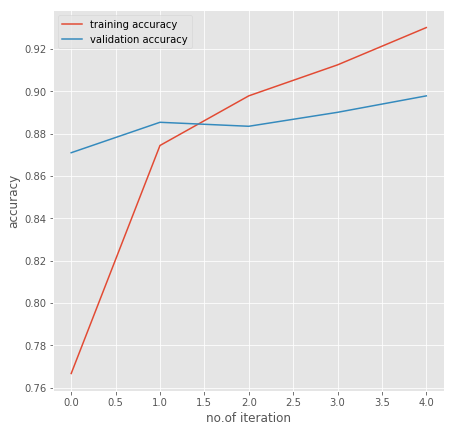

In [12]:
hist = pd.DataFrame(history.history)
import matplotlib.pyplot as plt
import pylab 
plt.style.use("ggplot")
plt.figure(figsize=(7,7))
pylab.plot(hist["acc"],label='training accuracy')
pylab.xlabel("no.of iteration")
pylab.ylabel("accuracy")
pylab.plot(hist["val_acc"],label='validation accuracy')
pylab.legend(loc='upper left')
plt.show()


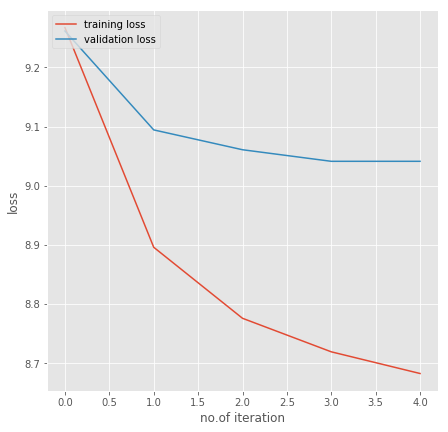

In [13]:
hist = pd.DataFrame(history.history)
import matplotlib.pyplot as plt
import pylab 
plt.style.use("ggplot")
plt.figure(figsize=(7,7))
pylab.plot(hist["loss"],label='training loss')
pylab.xlabel("no.of iteration")
pylab.ylabel("loss")
pylab.plot(hist["val_loss"],label='validation loss')
pylab.legend(loc='upper left')
plt.show()


             precision    recall  f1-score   support

          D       0.61      0.63      0.62       953
          O       0.94      0.97      0.95     11107
          T       0.53      0.16      0.25       689

avg / total       0.89      0.90      0.89     12749



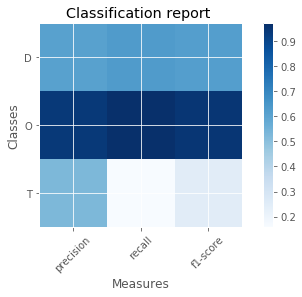

In [14]:
from sklearn.metrics import classification_report

report = classification_report(y_pred=predicted, y_true=actual)

def plot_classification_report(cr, title='Classification report ', with_avg_total=False, cmap=plt.cm.Blues):

    lines = cr.split('\n')

    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 3)]:
        #print(line)
        t = line.split()
        # print(t)
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        #print(v)
        plotMat.append(v)

    if with_avg_total:
        aveTotal = lines[len(lines) - 1].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)


    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')
    plt.show()
print(report)
plot_classification_report(report)
    

In [15]:
import pandas as pd
y_true = pd.Series(actual)
y_pred = pd.Series(predicted)

pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)


Predicted,D,O,T,All
True,,,,
D,604,309,40,953
O,244,10803,60,11107
T,143,435,111,689
All,991,11547,211,12749
